In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
from os import makedirs
path.append(abspath("/home/ng136/nico"))
import ng_functions as ng

from glob import glob
from pathlib import Path
import warnings
from time import time
from datetime import datetime
from tqdm import tqdm
import gseapy
import json 


In [2]:
print(datetime.today())

2023-01-06 05:33:36.782841


# Load annotated experiments 2 and 3

In [3]:
n_states = ['N1a', 'N1b', 'N2', 'N3', 'N4', 'N5', 'N6']

In [4]:
n_poles_dict = {'N1a': 'Sellhi',
                 'N1b': 'Sellhi',
                 'N2': 'Sellhi',
                 'N3': 'Cxcl3hi',
                 'N4': 'Siglecfhi',
                 'N5': 'Siglecfhi',
                 'N6': 'Siglecfhi'}

In [5]:
n_states_dict = {'N1a' : 'Sell+Ngp+ neutrophils',
                 'N1b' : 'Sell+Lst1+ neutrophils',
                 'N2' : 'Sell+Cxcl10+ neutrophils',
                 'N3' : 'Cxcl3+ neutrophils',
                 'N4' : 'Siglecf+Xbp1+ neutrophils',
                 'N5' : 'Siglecf+Ccl3+ neutrophils',
                 'N6' : 'Siglecf+Ngp+ neutrophils'}

neu_palette_dict = {'Sell+Ngp+ neutrophils': '#6EA6CD',
                    'Sell+Lst1+ neutrophils': '#4A7BB7',
                    'Sell+Cxcl10+ neutrophils': '#364B9A',
                    'Cxcl3+ neutrophils': '#EAECCC',
                    'Siglecf+Xbp1+ neutrophils': '#A50026',
                    'Siglecf+Ccl3+ neutrophils': '#DD3D2D',
                    'Siglecf+Ngp+ neutrophils': '#F67E4B'}

# Load data

In [6]:
ndata = sc.read('/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_untreated_annotated_embedding_5258x13126_backup_220422_15h46.h5ad')
tdata = sc.read('/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_neutrophils_acd40_annotated_embedding_25210x17824_backup_220422_15h46.h5ad')

In [7]:
hdata = ndata[ndata.obs.sample_condition.str.startswith('WT')].copy()
udata = ndata[ndata.obs.sample_condition.str.startswith('KP19')].copy()

# Filter out non-neutrophils

In [8]:
ndata = ndata[ndata.obs['smoothed_Zilionis'].isin(n_states)].copy()
hdata = hdata[hdata.obs['smoothed_Zilionis'].isin(n_states)].copy()
udata = udata[udata.obs['smoothed_Zilionis'].isin(n_states)].copy()
tdata = tdata[tdata.obs['smoothed_Zilionis'].isin(n_states)].copy()

# Concatenate untreated and aCD40-treated

In [9]:
utdata = sc.concat((udata, tdata), label='treatment', keys=('Untreated', 'aCD40'))

In [10]:
utdata.layers['scaled'] = utdata.layers['log1p'].copy()
sc.pp.scale(utdata, layer='scaled')

# Remove N3, coarse grain states

In [11]:
hdata_ss = hdata[hdata.obs['smoothed_Zilionis'] != 'N3'].copy()
hdata_ss.obs['neutrophil_group'] = hdata_ss.obs['smoothed_Zilionis'].map(n_poles_dict)

In [12]:
udata_ss = udata[udata.obs['smoothed_Zilionis'] != 'N3'].copy()
tdata_ss = tdata[tdata.obs['smoothed_Zilionis'] != 'N3'].copy()
utdata_ss = utdata[utdata.obs['smoothed_Zilionis'] != 'N3'].copy()

udata_ss.obs['neutrophil_group'] = udata_ss.obs['smoothed_Zilionis'].map(n_poles_dict)
tdata_ss.obs['neutrophil_group'] = tdata_ss.obs['smoothed_Zilionis'].map(n_poles_dict)
utdata_ss.obs['neutrophil_group'] = utdata_ss.obs['smoothed_Zilionis'].map(n_poles_dict)

utdata_sell = utdata_ss[utdata_ss.obs['neutrophil_group'] == 'Sellhi'].copy()
utdata_siglecf = utdata_ss[utdata_ss.obs['neutrophil_group'] == 'Siglecfhi'].copy()

# Parse genes from GO terms

In [13]:
gene_sets = { 'Immunosuppression' : ['Havcr2', 'Fcgr2b', 'Il4ra', 'Cd274', 'Hif1a'],
 'ECM remodeling' : ['Adamdec1','Ctsc', 'Ctsb', 'Rgcc', 'Ctss', 'Ctsz', 'Adam17', 'Adam10', 'Adam8'],
 'Tumor proliferation' : ['Tgfb1', 'Tnf', 'Il1a'],
 'Myeloid cell recruitment' : ['Ccl3', 'Mif', 'Cxcl14', 'Csf1', 'Vegfa', 'Ccl4', 'Cxcl3'],
 'Angiogenesis': ['Vegfa', 'Snd1', 'Mtdh', 'Itga5', 'Tnf', 'Cxcl3', 'Anxa3', 'Hmgb1', 'Hif1a', 'Sema4d', 'Lrg1', 'Chil1'],
 'Neutrophil degranulation' : ['Abr', 'Anxa3', 'Cd177', 'Itgam', 'Itgb2', 'Itgb2l', 'Pikfyve', 'Pram1', 'Ptafr', 'Spi1', 'Stx11', 'Syk'],
 'Neutrophil cytotoxicity' : ['Ncf1', 'Myd88', 'Trem3', 'Trem1', 'Tusc2', 'Cybb', 'Cybc1', 'Ncf2', 'Ncf4', 'Rac1', 'Rac2'],
 'Interferon signaling' : ['Adar', 'Isg15', 'Isg20', 'Rsad2', 'Ifit1', 'Ifit3', 'Ifitm1', 'Ifitm3', 'Irak1', 'Oas3', 'Stat1', 'Stat2', 'Irf7', 'Cxcl10']}


# Compute scores

In [14]:

exp_layer = 'scaled'

udata.X = udata.layers[exp_layer].copy()
tdata.X = tdata.layers[exp_layer].copy()
utdata.X = utdata.layers[exp_layer].copy()

udata_ss.X = udata_ss.layers[exp_layer].copy()
tdata_ss.X = tdata_ss.layers[exp_layer].copy()
utdata_ss.X = utdata_ss.layers[exp_layer].copy()
utdata_sell.X = utdata_sell.layers[exp_layer].copy()
utdata_siglecf.X = utdata_siglecf.layers[exp_layer].copy()

for gset in gene_sets.keys():

    sc.tl.score_genes(udata,  gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)
    sc.tl.score_genes(tdata,  gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)
    sc.tl.score_genes(utdata, gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)    
    
    sc.tl.score_genes(udata_ss,  gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)
    sc.tl.score_genes(tdata_ss,  gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)
    sc.tl.score_genes(utdata_ss, gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)
    sc.tl.score_genes(utdata_sell, gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)
    sc.tl.score_genes(utdata_siglecf, gene_list= gene_sets[gset], score_name=f'score_{ng.fix_filename(gset)}', use_raw=False)


udata.X = udata.layers['umi'].copy()
tdata.X = tdata.layers['umi'].copy()
utdata.X = utdata.layers['umi'].copy()
    
udata_ss.X = udata_ss.layers['umi'].copy()
tdata_ss.X = tdata_ss.layers['umi'].copy()
utdata_ss.X = utdata_ss.layers['umi'].copy()
utdata_sell.X = utdata_sell.layers['umi'].copy()
utdata_siglecf.X = utdata_siglecf.layers['umi'].copy()


In [15]:
protumor_scores = ['score_Angiogenesis', 'score_ECM_remodeling', 'score_Immunosuppression', 'score_Tumor_proliferation', 'score_Myeloid_cell_recruitment']
antitumor_scores = ['score_Neutrophil_degranulation', 'score_Neutrophil_cytotoxicity', 'score_Interferon_signaling']

In [16]:
sellscores = utdata_sell.obs.loc[:,(utdata_sell.obs.columns.str.contains('score')) | utdata_sell.obs.columns.isin(['treatment', 'library_name']) ].melt(var_name='score', ignore_index=False,
                                                                                                                                        id_vars=['treatment', 'library_name'])

sellscores = sellscores.groupby(['library_name', 'treatment', 'score']).mean().reset_index()


siglecfscores = utdata_siglecf.obs.loc[:,(utdata_siglecf.obs.columns.str.contains('score')) | utdata_siglecf.obs.columns.isin(['treatment', 'library_name']) ].melt(var_name='score', ignore_index=False,
                                                                                                                                        id_vars=['treatment', 'library_name'])

siglecfscores = siglecfscores.groupby(['library_name', 'treatment', 'score']).mean().reset_index()


uscores = udata_ss.obs.loc[:,(udata_ss.obs.columns.str.contains('score')) | udata_ss.obs.columns.isin(['neutrophil_group', 'library_name']) ].melt(var_name='score', ignore_index=False,
                                                                                                                                        id_vars=['neutrophil_group', 'library_name'])
uscores = uscores.groupby(['library_name', 'neutrophil_group', 'score']).mean().reset_index()


# Separate boxes

In [17]:
from scipy.stats import zscore

# Normalized scores

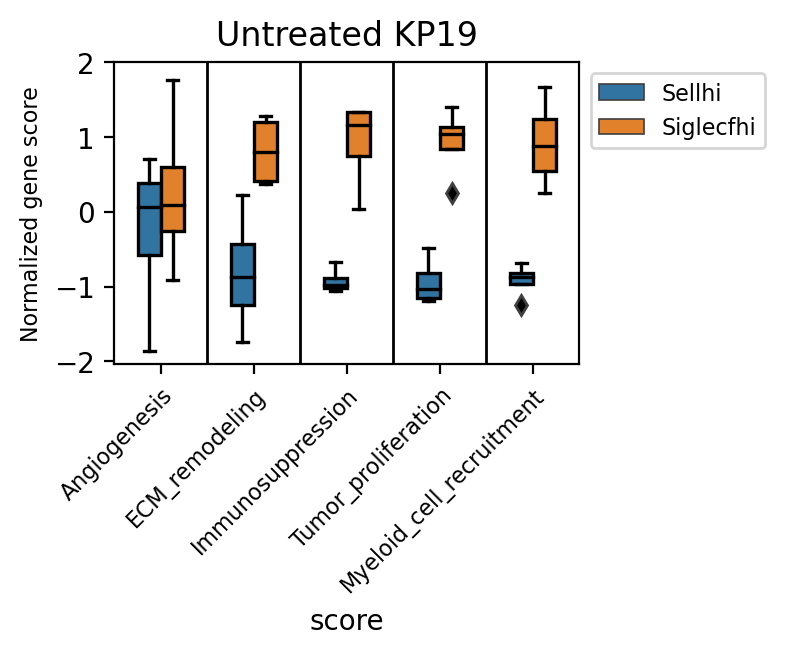

In [18]:
fig, ax = plt.subplots(1, dpi=200, figsize=(3,2))

sns.boxplot(data=zscore(uscores.pivot(index=['library_name','neutrophil_group'],columns=['score'], values='value')).reset_index().melt(id_vars=['library_name','neutrophil_group'])
.query(f'score in {protumor_scores}'), x='score', y='value', hue='neutrophil_group', 
           order= protumor_scores, ax=ax, width=0.5,
           medianprops=dict(color="black"),
           flierprops=dict(markerfacecolor="black", marker="d"), linewidth=1.2)

ax.legend(bbox_to_anchor=(1,1), fontsize=8)


ax.set_xticklabels([l._text[6:] for l in ax.get_xticklabels()])

[ax.axvline(0.5+i, c='k', lw=1) for i in range(5)]

ax.set_title('Untreated KP19')
ax.set_ylabel('Normalized gene score', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)

ax.set_yticks([-2, -1, 0, 1, 2])
plt.setp(ax.patches, edgecolor = 'black')
plt.setp(ax.lines, color = 'black')


plt.show()

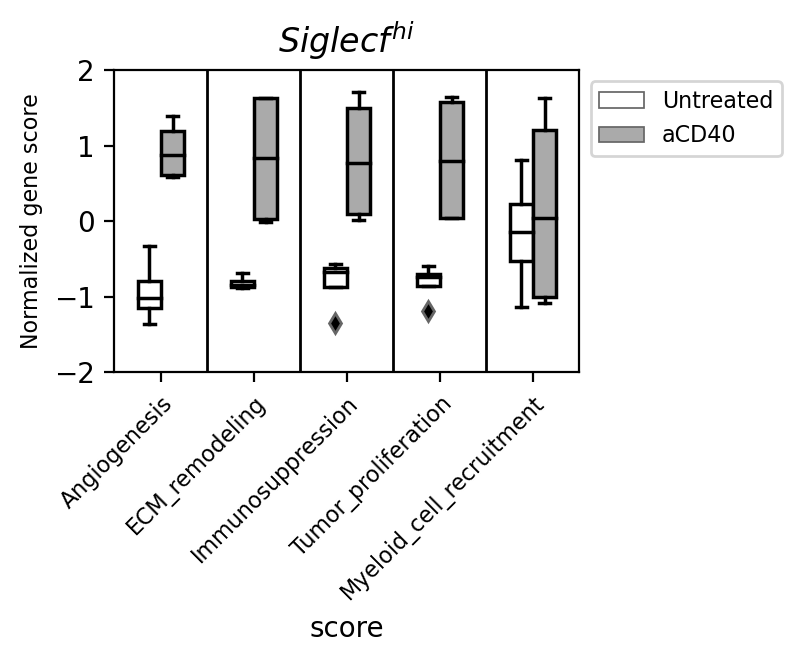

In [19]:
fig, ax = plt.subplots(1, dpi=200, figsize=(3,2))

sns.boxplot(data=zscore(siglecfscores.pivot(index=['library_name','treatment'],columns=['score'], values='value').dropna()).reset_index().melt(id_vars=['library_name','treatment'])
.query(f'score in {protumor_scores}'), x='score', y='value', hue='treatment', 
           order= protumor_scores, ax=ax, width=0.5, palette=['white', '#aaaaaa'],
           medianprops=dict(color="black"),
           flierprops=dict(markerfacecolor="black", marker="d"), linewidth=1.25)

ax.legend(bbox_to_anchor=(1,1), fontsize=8)


ax.set_xticklabels([l._text[6:] for l in ax.get_xticklabels()])

[ax.axvline(0.5+i, c='k', lw=1) for i in range(5)]

ax.set_title('$Siglecf^{hi}$')

ax.set_ylabel('Normalized gene score', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)

ax.set_yticks([-2, -1, 0, 1, 2])

plt.setp(ax.patches, edgecolor = 'black')
plt.setp(ax.lines, color = 'black')


plt.show()

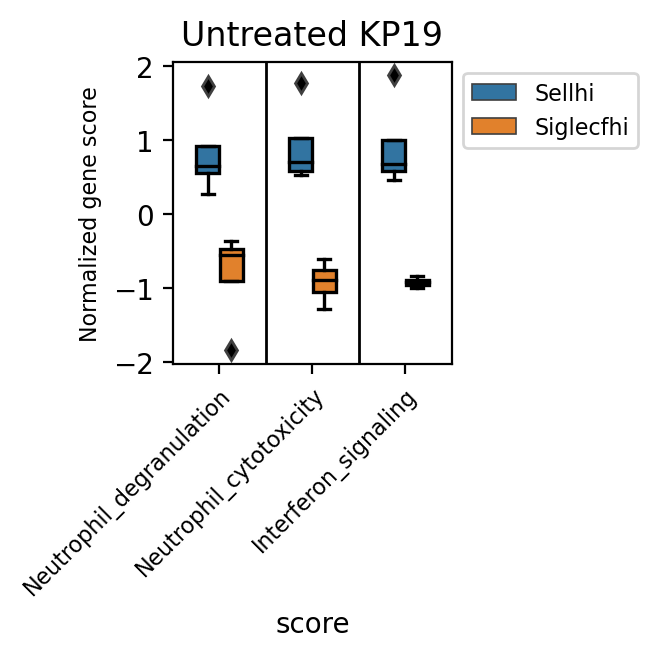

In [20]:
fig, ax = plt.subplots(1, dpi=200, figsize=(1.8,2))

sns.boxplot(data=zscore(uscores.pivot(index=['library_name','neutrophil_group'],columns=['score'], values='value')).reset_index().melt(id_vars=['library_name','neutrophil_group'])
.query(f'score in {antitumor_scores}'), x='score', y='value', hue='neutrophil_group', 
           order= antitumor_scores, ax=ax, width=0.5,
           medianprops=dict(color="black"),
           flierprops=dict(markerfacecolor="black", marker="d"), linewidth=1.2)

ax.legend(bbox_to_anchor=(1,1), fontsize=8)


ax.set_xticklabels([l._text[6:] for l in ax.get_xticklabels()])

[ax.axvline(0.5+i, c='k', lw=1) for i in range(3)]

ax.set_title('Untreated KP19')
ax.set_ylabel('Normalized gene score', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)

ax.set_yticks([-2, -1, 0, 1, 2])
plt.setp(ax.patches, edgecolor = 'black')
plt.setp(ax.lines, color = 'black')


plt.show()

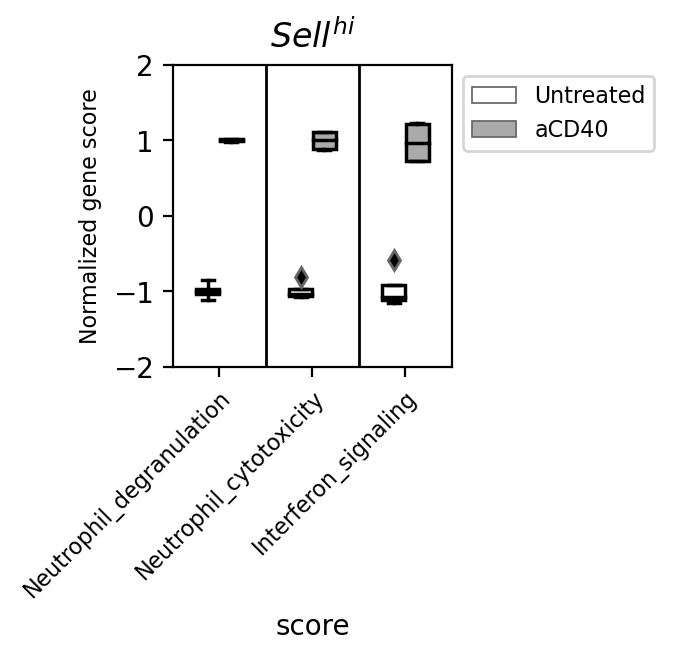

In [21]:
fig, ax = plt.subplots(1, dpi=200, figsize=(1.8,2))

sns.boxplot(data=zscore(sellscores.pivot(index=['library_name','treatment'],columns=['score'], values='value').dropna()).reset_index().melt(id_vars=['library_name','treatment'])
.query(f'score in {antitumor_scores}'), x='score', y='value', hue='treatment', 
           order= antitumor_scores, ax=ax, width=0.5, palette=['white', '#aaaaaa'],
           medianprops=dict(color="black"),
           flierprops=dict(markerfacecolor="black", marker="d"), linewidth=1.25)

ax.legend(bbox_to_anchor=(1,1), fontsize=8)


ax.set_xticklabels([l._text[6:] for l in ax.get_xticklabels()])

[ax.axvline(0.5+i, c='k', lw=1) for i in range(3)]

ax.set_title('$Sell^{hi}$')

ax.set_ylabel('Normalized gene score', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)

ax.set_yticks([-2, -1, 0, 1, 2])

plt.setp(ax.patches, edgecolor = 'black')
plt.setp(ax.lines, color = 'black')


plt.show()

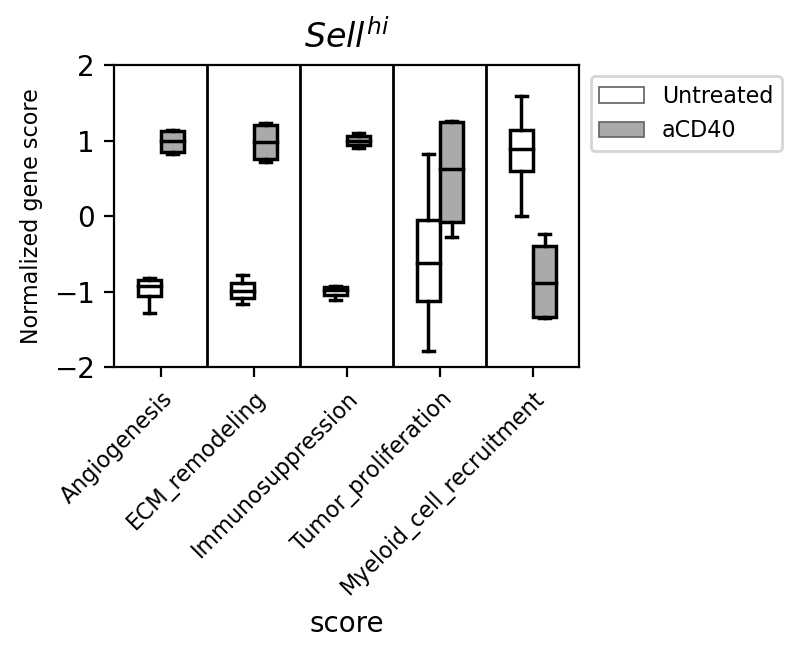

In [22]:
fig, ax = plt.subplots(1, dpi=200, figsize=(3,2))

sns.boxplot(data=zscore(sellscores.pivot(index=['library_name','treatment'],columns=['score'], values='value').dropna()).reset_index().melt(id_vars=['library_name','treatment'])
.query(f'score in {protumor_scores}'), x='score', y='value', hue='treatment', 
           order= protumor_scores, ax=ax, width=0.5, palette=['white', '#aaaaaa'],
           medianprops=dict(color="black"),
           flierprops=dict(markerfacecolor="black", marker="d"), linewidth=1.25)

ax.legend(bbox_to_anchor=(1,1), fontsize=8)


ax.set_xticklabels([l._text[6:] for l in ax.get_xticklabels()])

[ax.axvline(0.5+i, c='k', lw=1) for i in range(5)]

ax.set_title('$Sell^{hi}$')

ax.set_ylabel('Normalized gene score', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)

ax.set_yticks([-2, -1, 0, 1, 2])

plt.setp(ax.patches, edgecolor = 'black')
plt.setp(ax.lines, color = 'black')


plt.show()